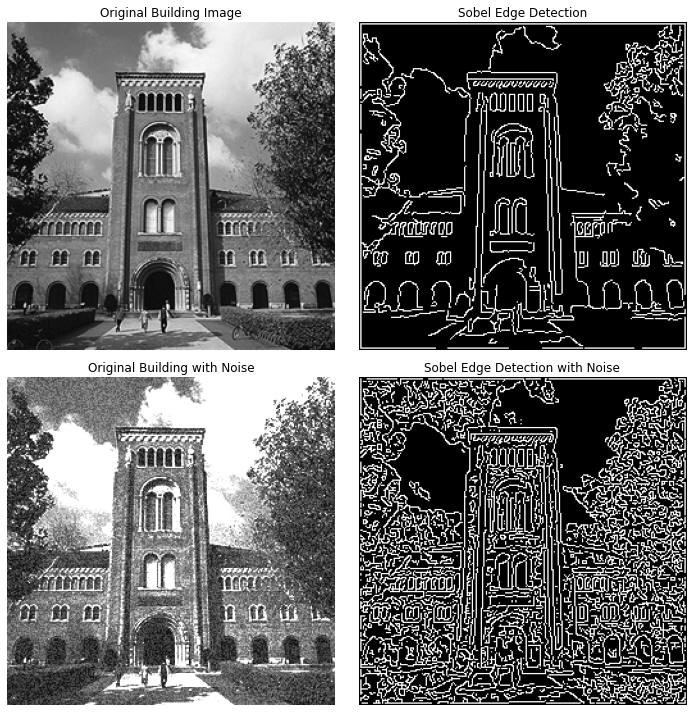

In [13]:
import numpy as np
from scipy import ndimage
from skimage import feature
import matplotlib.pyplot as plt

# Consolidating the edge detection methods into one with a parameter to switch between methods
def edge_detection(image, method='sobel', sigma=1.0):
    if method == 'sobel':
        return feature.canny(image, sigma=sigma)
    elif method == 'log':
        blurred = ndimage.gaussian_filter(image, sigma=sigma)
        laplacian = ndimage.laplace(blurred)
        zero_crossings = np.where(np.diff(np.sign(laplacian), axis=0), 1, 0)
        return zero_crossings

# We load the images only once as they are used multiple times.
# We also pass the shape as a parameter to make the function more general.
def load_and_process_image(file_path, shape=(256, 256), method='sobel', sigma=1.0):
    try:
        # Load image from file
        with open(file_path, 'rb') as rawfile:
            img = np.fromfile(rawfile, dtype=np.uint8).reshape(shape)
        # Process image
        edges = edge_detection(img, method=method, sigma=sigma)
        return img, edges
    except IOError:
        print(f"Error: File {file_path} not accessible.")
        return None, None

# Load the images and process them
building_image, edges_building = load_and_process_image('./Project2_Images/building.raw')
building_noise_image, edges_building_noise = load_and_process_image('./Project2_Images/building_noise.raw')
_, edges_building_log = load_and_process_image('./Project2_Images/building.raw', method='log', sigma=2)
_, edges_building_noise_log = load_and_process_image('./Project2_Images/building_noise.raw', method='log', sigma=2)

# Check if images were loaded successfully before proceeding to plot
if building_image is not None and building_noise_image is not None:
    # Plot the results using a more concise loop
    titles = ['Original Building Image', 'Sobel Edge Detection',
              'Original Building with Noise', 'Sobel Edge Detection with Noise']
    images = [building_image, edges_building, building_noise_image, edges_building_noise]

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for ax, img, title in zip(axes.ravel(), images, titles):
        ax.imshow(img, cmap=plt.cm.gray)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


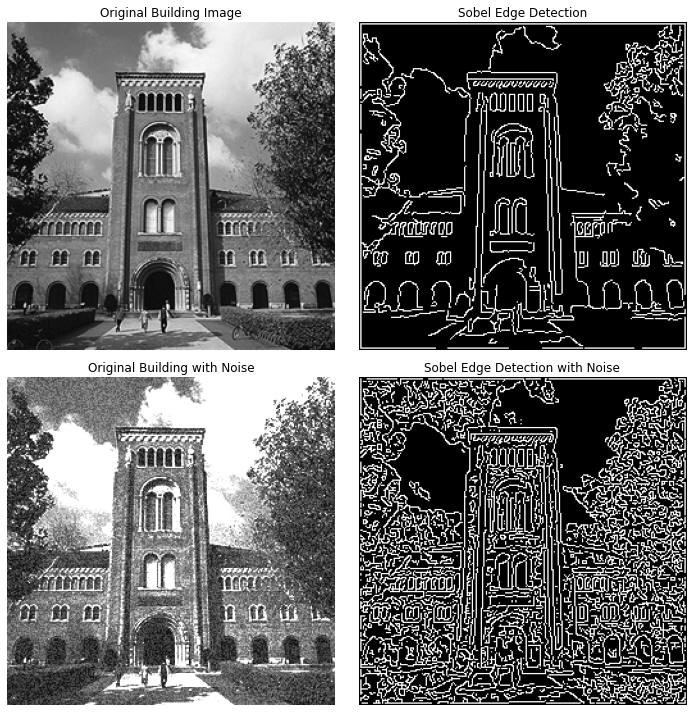

In [16]:
import numpy as np
from scipy import ndimage
from skimage import feature, exposure, morphology, filters
import matplotlib.pyplot as plt

def edge_detection(image, method='sobel', sigma=1.0):
    if method == 'sobel':
        return feature.canny(image, sigma=sigma)
    elif method == 'log':
        blurred = ndimage.gaussian_filter(image, sigma=sigma)
        laplacian = ndimage.laplace(blurred)
        zero_crossings = np.where(np.diff(np.sign(laplacian), axis=0), 1, 0)
        return zero_crossings

def pre_process_image(image, method='equalization'):
    if method == 'equalization':
        # Histogram Equalization
        return exposure.equalize_hist(image)
    elif method == 'clahe':
        # Contrast Limited Adaptive Histogram Equalization
        clahe = exposure.equalize_adapthist(image, clip_limit=0.03)
        return clahe

def post_process_edges(edges, min_size=64):
    # Remove small objects
    cleaned_edges = morphology.remove_small_objects(edges.astype(bool), min_size=min_size)
    return cleaned_edges

def remove_noise(image, method='gaussian', sigma=1.0):
    if method == 'gaussian':
        # Gaussian Blur
        return ndimage.gaussian_filter(image, sigma=sigma)
    elif method == 'median':
        # Median Filter
        return filters.median(image)

# ... existing load_and_process_image function ...

# Example usage in your existing loading and plotting section:
# Pre-process the image for contrast enhancement
building_image_eq = pre_process_image(building_image, method='equalization')
building_noise_image_denoised = remove_noise(building_noise_image, method='median', sigma=2)

# Edge detection on the pre-processed images
# ... existing functions ...

# Edge detection on the pre-processed images
edges_building_eq = edge_detection(building_image_eq, method='sobel', sigma=1)
edges_building_noise_denoised = edge_detection(building_noise_image_denoised, method='sobel', sigma=1)

# Post-process the edges to clean up
edges_building_eq_post = post_process_edges(edges_building_eq)
edges_building_noise_denoised_post = post_process_edges(edges_building_noise_denoised)

if building_image is not None and building_noise_image is not None:
    # Plot the results using a more concise loop
    titles = ['Original Building Image', 'Sobel Edge Detection',
              'Original Building with Noise', 'Sobel Edge Detection with Noise']
    images = [building_image, edges_building, building_noise_image, edges_building_noise]

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for ax, img, title in zip(axes.ravel(), images, titles):
        ax.imshow(img, cmap=plt.cm.gray)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()



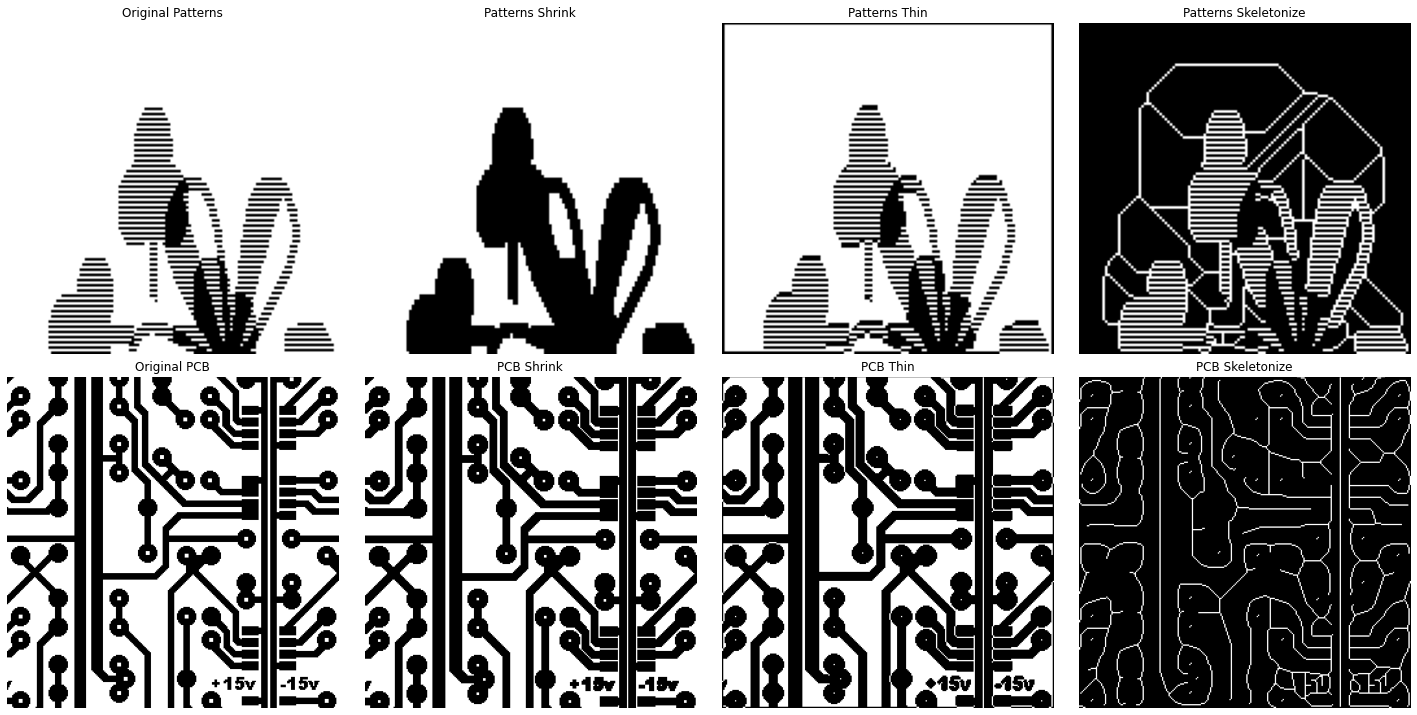

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import skeletonize, thin

# Let's define a function to read raw images, since they are not standard image files.
def read_raw_image(path, width, height):
    # Assuming the images are grayscale
    with open(path, 'rb') as f:
        img = np.fromfile(f, dtype=np.uint8, count=width*height)
        img = img.reshape((height, width))
    return img

# Define a function to apply morphological operations
def morphological_operations(image, operation):
    if operation == 'shrink':
        # Use cv2.erode to apply shrinking
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
        return cv2.erode(image, kernel, iterations=1)
    elif operation == 'thin':
        # Use skimage's thin function
        return thin(image, max_num_iter=1)
    elif operation == 'skeletonize':
        # Use skimage's skeletonize function
        return skeletonize(image // 255) * 255  # skimage expects boolean image
    else:
        raise ValueError("Unsupported operation")

# Read the images
patterns_img = read_raw_image("./Project2_Images/patterns.raw", 128, 128)  # Assuming 128x128 size for example
pcb_img = read_raw_image('./Project2_Images/pcb.raw', 256, 256)  # Assuming 256x256 size for example

# Apply the morphological operations
patterns_shrink = morphological_operations(patterns_img, 'shrink')
patterns_thin = morphological_operations(patterns_img, 'thin')
patterns_skeletonize = morphological_operations(patterns_img, 'skeletonize')

pcb_shrink = morphological_operations(pcb_img, 'shrink')
pcb_thin = morphological_operations(pcb_img, 'thin')
pcb_skeletonize = morphological_operations(pcb_img, 'skeletonize')

# Display the results
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# Original images
axs[0, 0].imshow(patterns_img, cmap='gray')
axs[0, 0].title.set_text('Original Patterns')
axs[1, 0].imshow(pcb_img, cmap='gray')
axs[1, 0].title.set_text('Original PCB')

# Shrinking results
axs[0, 1].imshow(patterns_shrink, cmap='gray')
axs[0, 1].title.set_text('Patterns Shrink')
axs[1, 1].imshow(pcb_shrink, cmap='gray')
axs[1, 1].title.set_text('PCB Shrink')

# Thinning results
axs[0, 2].imshow(patterns_thin, cmap='gray')
axs[0, 2].title.set_text('Patterns Thin')
axs[1, 2].imshow(pcb_thin, cmap='gray')
axs[1, 2].title.set_text('PCB Thin')

# Skeletonizing results
axs[0, 3].imshow(patterns_skeletonize, cmap='gray')
axs[0, 3].title.set_text('Patterns Skeletonize')
axs[1, 3].imshow(pcb_skeletonize, cmap='gray')
axs[1, 3].title.set_text('PCB Skeletonize')

# Remove the axis labels for clarity
for ax in axs.flat:
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


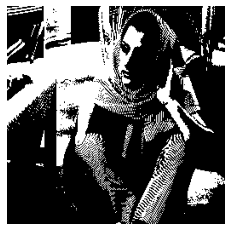

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Complete Python code to implement Fixed Threshold Dithering on the 'barbara.raw' image

# Define the threshold T
T = 127

# Read the raw image data
image_path = "./Project2_Images/barbara.raw"
# We now know the image size is 256x256 from the previous attempt
image_size = 256

# Load the image data
with open(image_path, 'rb') as file:
    img_data = np.fromfile(file, dtype=np.uint8)
    img_data = img_data.reshape((image_size, image_size))

# Apply fixed threshold dithering
binary_img = np.where(img_data < T, 0, 255)

# Display the binary image
plt.imshow(binary_img, cmap='gray')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


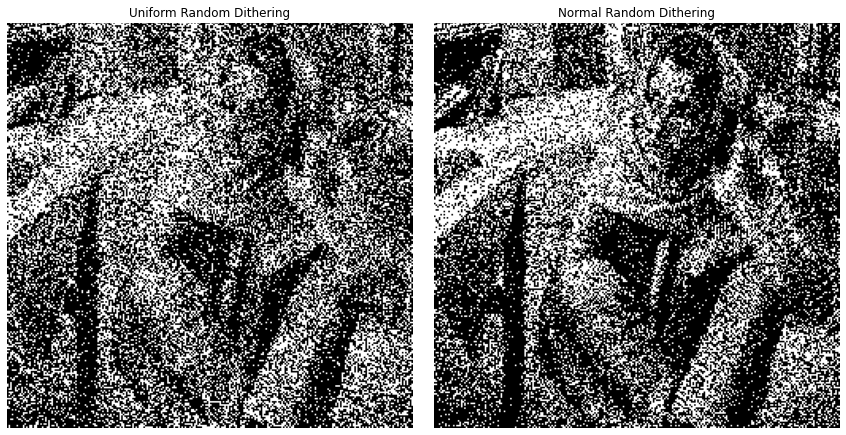

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Complete Python code to perform Random Dithering on 'barbara.raw' image

# Load the image data
image_path = './Project2_Images/barbara.raw'
image_size = 256  # Image dimensions (256x256)

with open(image_path, 'rb') as file:
    img_data = np.fromfile(file, dtype=np.uint8).reshape((image_size, image_size))

# Function to perform random dithering using a uniform distribution
def random_dithering_uniform(image_data):
    random_threshold = np.random.randint(0, 256, image_data.shape)
    return np.where(image_data < random_threshold, 0, 255)

# Function to perform random dithering using a normal distribution
def random_dithering_normal(image_data):
    # Generate random numbers with a mean of 127 and std deviation such that most values fall within 0-255
    random_threshold = np.random.randn(*image_data.shape) * 64 + 127
    random_threshold = np.clip(random_threshold, 0, 255)  # Clip to ensure values are within range
    return np.where(image_data < random_threshold, 0, 255)

# Perform random dithering with both distributions
binary_img_uniform = random_dithering_uniform(img_data)
binary_img_normal = random_dithering_normal(img_data)

# Display the binary images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Uniform random dithering
ax[0].imshow(binary_img_uniform, cmap='gray')
ax[0].set_title('Uniform Random Dithering')
ax[0].axis('off')

# Normal random dithering
ax[1].imshow(binary_img_normal, cmap='gray')
ax[1].set_title('Normal Random Dithering')
ax[1].axis('off')

plt.tight_layout()
plt.show()
